# EC2-A4: Generate QuickDraw drawings with an RNN

### Jing Qian (jq2282)

Generate QuickDraw drawings with an RNN. 
Bonus points: include an animated GIF showing the drawings being created step by step.

https://github.com/tensorflow/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN.ipynb

# Step 1. Load the Quick Draw dataset

## Get "rabbit" data

In [0]:
from __future__ import print_function

import functools, itertools, json, os, re, textwrap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image, ImageDraw
from six.moves.urllib import request
from xml.dom import minidom

In [0]:
# Retrieve list of classes.
def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')

In [0]:
# Store all data locally in this directory.
data_path = 'data'
if not os.path.exists(data_path): 
  os.mkdir(data_path)

In [0]:
# Download the chosen group.
def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except (ValueError, IOError):
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

name = "rabbit"
print(name, end=' ')
dst = '%s/%s.ndjson' % (data_path, name)
retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
print('%.2f MB' % (os.path.getsize(dst) / 2.**20))

print('\nDONE :)')

rabbit 95.05 MB

DONE :)


## Inspect the data

In [0]:
#Let's check out the downloaded files...
!ls -lh $data_path
#What is the NDJSON file format?
#Seems to be one JSON dictionary per line...
path = tf.gfile.Glob(os.path.join(data_path, '%s.ndjson'%name))[0]
print(str(path)+ '...')

# Parse single line.
data_json = json.loads(open(path).readline())
data_json.keys()


# ...and the actual drawing.
drawing = data_json['drawing']
# The drawing consists of a series of strokes:
[np.array(stroke).shape for stroke in drawing]

total 227M
-rw-r--r-- 1 root root 59M May  2 16:18 bat.ndjson
-rw-r--r-- 1 root root 74M May  2 16:12 cat.ndjson
-rw-r--r-- 1 root root 96M May  2 16:13 rabbit.ndjson
data/rabbit.ndjson...


[(2, 13), (2, 2), (2, 2), (2, 2), (2, 5), (2, 9), (2, 7), (2, 16), (2, 7)]

In [0]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:

def draw_strokes(drawing):
  # Use a different color for each stroke
  colors = cm.rainbow(np.linspace(0, 1, len(drawing)))
  plt.axis('off')
  for stroke, c in zip(drawing, colors):
    #print(stroke[0], stroke[1])
    plt.plot(np.array(stroke[0]), -1 * np.array(stroke[1]), color=c)
    
#draw_strokes(drawing)

In [0]:

# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

print('loading some "%s"...' % name)
sample = loadn(name, 100)

loading some "rabbit"...


In [0]:
sample[0]

{'countrycode': 'US',
 'drawing': [array([[ 87,  34,  20,  12,  14,  31,  71,  88, 101, 109, 112, 109, 104],
         [ 58,  68,  77,  94, 104, 110, 109, 104,  94,  79,  55,  51,  50]]),
  array([[59, 59],
         [89, 89]]),
  array([[59, 59],
         [88, 88]]),
  array([[39, 38],
         [84, 85]]),
  array([[ 31,  36,  46,  85, 105],
         [ 69,  72,  73,  66,  74]]),
  array([[39, 25, 14,  8,  3, 31, 42, 56, 71],
         [58, 45, 30, 19,  0,  6, 11, 28, 55]]),
  array([[ 95, 129, 143, 151, 150, 142, 115],
         [ 49,  22,  18,  21,  35,  54,  94]]),
  array([[ 61,  20,  11,   6,  10,  18,  27,  43,  60,  87,  99, 105, 103,
           92,  76,  52],
         [110, 114, 121, 138, 167, 189, 202, 210, 208, 194, 180, 159, 140,
          126, 113, 109]]),
  array([[ 29,  18,  10,   0,   4,  22,  19],
         [207, 209, 214, 242, 247, 250, 255]])],
 'key_id': '6499801011060736',
 'recognized': True,
 'timestamp': '2017-03-06 16:00:48.38159 UTC',
 'word': 'rabbit'}

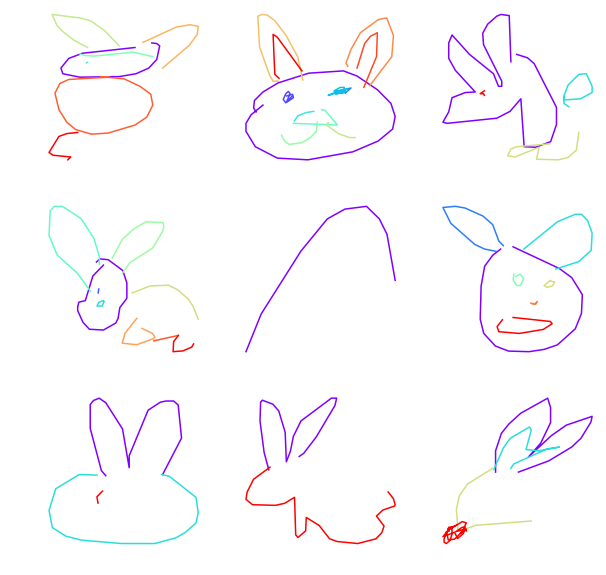

In [89]:
# Some more drawings...
plt.figure(figsize=(10, 10))
n = 3
for x in range(n):
    for y in range(n):
        i = x * n + y
        plt.subplot(n, n, i + 1)
        drawing = sample[i]['drawing']
        draw_strokes(drawing)

In [0]:
# Let's first check how many [recognized=True] examples we have in class.
# Depending on your choice of classes you could generate >200k examples / class...
print(name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

rabbit 155288 recognized 133323


# Step 2/ Train RNN model!

参照 https://github.com/eyalzk/sketch_rnn_keras/blob/master/Sketch_RNN_Keras.ipynb？ 

## Preprocessing

In [0]:
for i in range(len(stroke)):
  print(i, np.shape(stroke[i]))

0 (2, 16)
1 (2, 12)
2 (2, 11)
3 (2, 2)
4 (2, 2)
5 (2, 3)
6 (2, 3)


In [0]:
print(max_seq_len)

29


In [91]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(stroke, max_seq_len)

ValueError: ignored

In [92]:
stroke[0]

array([[122, 118,  81,  48,  32,  21,  14,  16,  30,  58,  73,  97, 110,
        118, 119, 109],
       [157, 153, 146, 147, 157, 175, 199, 221, 235, 251, 255, 253, 240,
        228, 195, 156]])

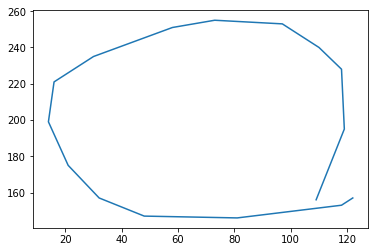

In [93]:
x,y=[],[]
for i in range(len(stroke[0][0])):
  x.append(stroke[0][0][i])
  y.append(stroke[0][1][i])
plt.plot(x,y)
plt.show()

In [0]:
def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:][0:2] = big_stroke[0:l][0:2]
    result[:][2] = big_stroke[0:l][3]
    return result
  
def to_big_strokes(stroke, max_len=250):
    """Converts from stroke-3 to stroke-5 format and pads to given length."""
    # (But does not insert special start token).

    result = np.zeros((max_len, 5), dtype=float)
    l = len(stroke)
    assert l <= max_len
    result[0:l][0:2] = stroke[:][0:2]
    result[0:l][3] = stroke[:][2]
    result[0:l][2] = 1 - result[0:l][3]
    result[l:][4] = 1
    return result

In [0]:
all_strokes = []
max_seq_len = 0
for i in sample:
  all_strokes.append(i['drawing'])
  max_seq_len = max(max_seq_len, len(i['drawing']))

In [0]:
# Function for encoding input and retrieving latent vector
def encode(input_strokes, draw=False):
    strokes = to_big_strokes(input_strokes, max_len=max_seq_len-1).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    if draw:
        draw_strokes(to_normal_strokes(np.array(strokes)))
    strokes = np.expand_dims(strokes, axis=0)
    return seq2seq.sample_models['encoder_model'].predict(strokes)

In [0]:
# Function for decoding a latent space factor into a sketch
def decode(z_input=None, draw_mode=True):
    z = None
    if z_input is not None:
        z = z_input
    sample_strokes, m = sample(seq2seq, seq_len=max_seq_len, temperature=temperature, z=z)
    strokes = to_normal_strokes(sample_strokes)
    if draw_mode:
        draw_strokes(strokes, factor)
    return strokes

ValueError: ignored

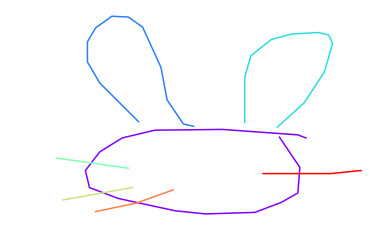

In [0]:
# test encode and decode
stroke = sample[58]['drawing']
draw_strokes(stroke)
z = encode(stroke)
print(z)
_ = decode(z)


In [96]:
encoder(stroke[0],20)

TypeError: ignored